In [36]:
# hide
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import choice
import scipy.optimize as optimize
from typing import List, Tuple
import seaborn as sns

sns.set_style('whitegrid')

# Pooling: Fake coins and infectious disease
> "How to speed up detection and testing"
- toc: true
- branch: master
- hide: false
- search_exclude: true
- show_tags: true

![image](../assets/coins.jpg)

## Fake coins

Imagine there are 1000 coins out of which 1% are fake, weighing a little less than a real coin.
What is the fastest way to identify those 10 fake coins.

The slowest way would be to weigh each coin one-by-one, which will require 1000 weighings. Can we do better? Yes.

The idea is called pooling. We divide the coins into pools of coins, which we weigh together.
As we know the weight of a pool of real coins, we would know which pools contain fake coins.

**What is the advantage of pooling?**

The probability of any coin being fake is $r=0.01$ (the prevalence of fakes in the available coins).
Therefore, the probability of a pool of $s_1$ coins having at least one fake coin is:

\begin{equation}
p_1 = 1 - (1-r)^{s_1}.
\end{equation}

This is the complementary probability of all the coins being real $(1-r)^{s^1}$.

If we divide the $N=1000$ coins into $N/s_1$ pools and weigh each pool, the expected number of pools that contain at least one fake coin are: $p_1\frac{N}{s_1}$. The power of the pooling technique is that $(1-p_1)\frac{N}{s_1}$ pools, will have all real coins, and therefore can be discarded.
The coins in the remainig suspicious pools can then be weighed individually. What is the total number of weighings we need to do?

\begin{equation}
T = N(\frac{1}{s_1} + p_1)
\end{equation}

As an example, if we choose $s_1=20$ we get that the expected number of tests 
to be able to identify all fake coins is: $232$, more than a factor 4 improvement.
We see that the number of tests as a fraction of $N$ is independent of $N$.

**How to choose the optimal pool size?**

To get the optimal pool size, we need to minimize the expression for the number of tests $T$, by varying $s_1$.

In [37]:
def tests(pools: List[float], r: float) -> float:
  """
  Calculate expected value of tests, as percentage of population
  """
  def p_frac(s: int, r: float) -> float:
    """
    helper function to Calculate p 
    from prevelance r and pool size s
    """
    return 1 - (1 - r)**s

  r_val = r/100.0
  total_tests = 0
  r_vals = [r_val]
  p_vals = [1]
  s_vals = []
  for i in range(len(pools)):
    s_vals.append((pools[i]))
    p_vals.append(p_frac(s_vals[i], r_vals[i]))
    r_vals.append(r_vals[i]/p_vals[i+1])
    total_tests += 1/s_vals[i]*np.prod(p_vals[:-1])

  total_tests += np.prod(p_vals)
  return total_tests*100


def optim(n_pools: int, r: float) -> Tuple:
  """
  Find optimal pool sizes for given number of poolings
  and prevalance r.
  parameters:
    - n_pools: number of pools
    - r: prevalance (percentage)
  returns:
    list of pool sizes and expected number of tests as 
    percentage of population
  """

  initial_pools = [5*(i+1) for i in range(n_pools)]
  initial_pools.reverse()
  bounds = [(1,5000)]*n_pools

  res = optimize.minimize(tests, 
                          initial_pools,  
                          bounds=bounds,
                          method='L-BFGS-B', 
                          options={'maxiter':5e7}, 
                          args=(r),
                          tol=1e-15)
  s=[]
  for v in res.x:
    s.append(v)
  T = tests(s, r)
  return s, T

Using the above optimization method for prevalence of $1\%$ gives:

In [71]:
# hide_input
N=1000
print(f"Optimal pool size:  {int(np.floor(optim(n_pools=1, r=1)[0][0]))}")
print(f"Number of weighings:  {int(np.ceil(optim(n_pools=1, r=1)[1]*N/100))}")

Optimal pool size:  10
Number of weighings:  196


A significant improvement over the original $1000$ weighings.

A natural extension is to continue the pooling, known as nested-pooling, i.e. we divide the pools following the first weighing to new pools, with a different pool size, which can again be determiend by minimizing the expression for the number of test, in this case of 2-pools given by a slightly more complex expression:

\begin{equation}
\frac{T}{N} = \frac{1}{s_1} + \frac{p_2}{s_2} + p_1p_2N
\end{equation}

where $s_1, s_2$ are the first and second pool sizes, respectively.
$p_1$ is as before, and $p_2 = 1 - (1-\frac{r}{p_1})^{s_2}$ is the modified probability for the second batch of pools.

I've been using the word "expected" number of weighings because we are dealing with probabilities and randomness in the separation of the coins into pools, therefore we are dealing with a distribution of possible values, the expected value of which is given by
the formulas above. 
To demonstrate this we can actually run simulations of the pooling and record the number of required weighings.

In [41]:
def run_tests(S1:int = 9, S2:int = None, r:float = 1, N:int = 10**6) -> float:
    """
    Run pooling and testing simulation (up to 2 pools)
    retuns number of tests as fraction of population
    parameters:
        N - populationsize
        S - pool size
        r - prevalence (%)
    returns:
        tests as precentage of population
    """
    pop = np.arange(1,N+1)
    infected = set(choice(pop, int(r/100.*N), replace=False)) 
    n_buckets = int(np.ceil(N/S1))

    pop_perm = np.random.permutation(pop)
    buckets = np.array_split(pop_perm, n_buckets)
    
    positive_pop = []
    for bucket in buckets:
      if not infected.isdisjoint(bucket):
        positive_pop.extend(bucket)

    if S2:
      # second pool
      n_buckets2 = int(np.ceil(len(positive_pop)/S2))
      positive_pop_perm = np.random.permutation(positive_pop)
      buckets2 = np.array_split(positive_pop_perm, n_buckets2)

      positive_pop2 = set()
      for bucket in buckets2:
        if not infected.isdisjoint(bucket):
          positive_pop2.update(bucket)

      total_tests = len(buckets) + len(buckets2) + len(positive_pop2)
    else:
      # Total number of test to get individual results
      total_tests = n_buckets + len(positive_pop)

    # fraction of population tested 
    pop_frac = (total_tests)*100/N
    return pop_frac

Running the tests multiple times for our example of the coins gives.

In [96]:
N=1000
a=[]
for i in range(1000):
  a.append(run_tests(S1=10, r=1, N=1000))
print(f"Weighings = {N*np.mean(a)/100:.0f} +- {N/100*np.std(a):.0f}")

Weighings = 196 +- 6


We can also simulate for different pool sizes and check if the above choice is indeed optimal.

In [93]:
s=np.arange(5,20)
means = []
for s1 in s:
    a=[]
    for i in range(1000):
        a.append(run_tests(S1=s1, r=1, N=1000))
    means.append(np.mean(a)*N/100)

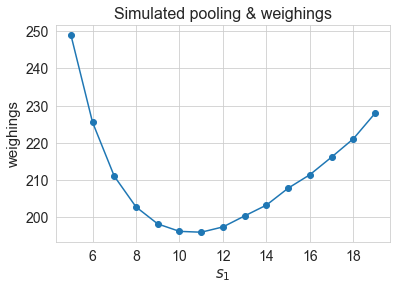

In [94]:
# hide_input
plt.plot(s,means,marker='o');
plt.xlabel(r'$s_1$', fontsize=15);
plt.ylabel('weighings', fontsize=15);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Simulated pooling & weighings", fontsize=16);

What about 2-pools? The above optimization method gives:

In [106]:
# hide_input
N=1000
pools = np.floor(optim(n_pools=2, r=1)[0]).astype(int)
weighings = int(np.ceil(optim(n_pools=2, r=1)[1]*N/100))
print(f"Optimal pools size:  {pools}")
print(f"Total number of weighings: {weighings}")

Optimal pools size:  [24  5]
Total number of weighings: 131


A further reduction of 65 weighings.

Note that pooling is most efficient when the prevelance is low, allowing to discard larger number of pools.

## Infectious disease

This idea of pooling can be generalized to the case of detecting infected individuals in a susceptible population
for an infectious disease. The crucial difference is the "weighing" method, which in the case of detecting infected individuals, is the [qPCR](https://en.wikipedia.org/wiki/Real-time_polymerase_chain_reaction) method, which is highly accurate way to identify the presence of a target DNA/RNA in a pooled sampled of DNAs.

My friend Yossi Eliaz ([@YossiElieaz](https://twitter.com/yossieliaz)) and I have explored this in a [paper](https://www.medrxiv.org/content/10.1101/2020.04.25.20079343v2) we published in medRxiv
recently, demonstrating the great benefits of the pooling technique for testing for SARS-CoV-2 in a  population with an estimated prevalance obtained from a SIRD model fit to reported infections and deaths.
Alongside the paper we've also made a streamlit [app](https://poolkeh.herokuapp.com/) allowing to find the optimal pooling strategy for different countries based on prevalence estimates.